In [1]:
import numpy as np
import pandas as pd
from utils import plan2data
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sgptools.utils.gpflow import *
from sgptools.utils.metrics import get_rmse

import tensorflow as tf
tf.random.set_seed(2024)
np.random.seed(2024)

2024-08-10 16:08:08.872761: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-10 16:08:08.875232: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-10 16:08:08.921207: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-10 16:08:08.922680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-10 16:08:09.685707: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def df2set(path):
    df = pd.read_csv(path+'data.csv')
    df = df.dropna()

    x1 = df['DPTH.Lng'].to_numpy()
    x2 = df['DPTH.Lat'].to_numpy()
    X = np.vstack([x2, x1]).T*1e-7
    X = X_scaler.transform(X)
    y = df['DPTH.Depth'].to_numpy().reshape(-1, 1)

    return X, y

# Boundary 

In [3]:
plan_fname = '../launch/plans/lake.plan'

# Get the data and normalize 
X_train, home_position = plan2data(plan_fname, 
                                   num_samples=5000)

X_train = np.array(X_train).reshape(-1, 2)
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)

X_train, home_position = plan2data(plan_fname, 
                                   num_samples=20000)
X_train = X_scaler.transform(X_train)

In [4]:
import json

# Extract geofence and home location from QGC plan file
def plan2vertices(fname, num_samples=5000):
    with open(fname, "r") as infile:
        data = json.load(infile)
        vertices = np.array(data['geoFence']['polygons'][0]['polygon'])
    vertices = np.vstack([vertices, vertices[0]])
    return vertices

boundary = plan2vertices(plan_fname)
boundary = X_scaler.transform(boundary)

# Lawn Mower 

(3504, 2) (3504, 1)


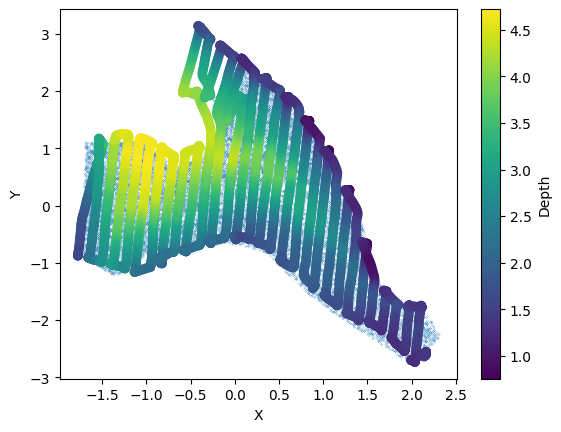

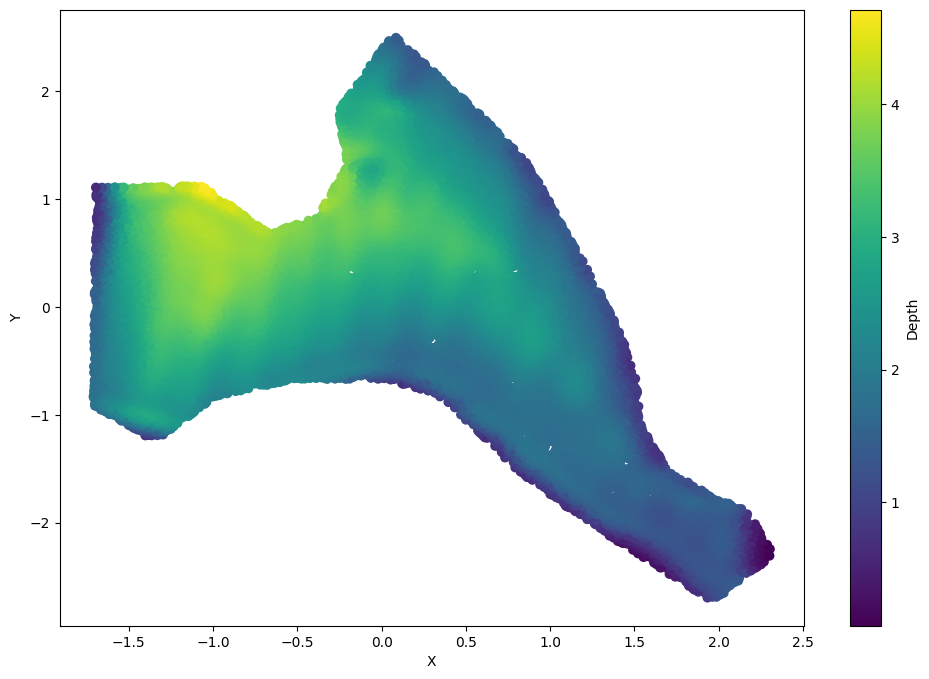

In [5]:
path = '../data/20240726/ASV1/mission5/'
X_gt, y_gt = df2set(path)
X_gt, y_gt = X_gt[::4], y_gt[::4]
print(X_gt.shape, y_gt.shape)

plt.scatter(X_train[:, 1], X_train[:, 0], marker='.', s=0.1)
plt.scatter(X_gt[:, 1], X_gt[:, 0], c=y_gt)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Depth')
plt.show()

kernel = gpflow.kernels.SquaredExponential(lengthscales=0.1, 
                                           variance=0.5)
gpr_gt = gpflow.models.GPR(data=(X_gt, y_gt), 
                           kernel=kernel)

y_labels, _ = gpr_gt.predict_f(X_train)
y_labels = y_labels.numpy()

plt.figure(figsize=(12, 8))
plt.scatter(X_train[:, 1], X_train[:, 0], c=y_labels)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Depth')
plt.savefig('lawn_mower.png', bbox_inches='tight')
plt.show()

# 2R-Discrete-15

1.8710


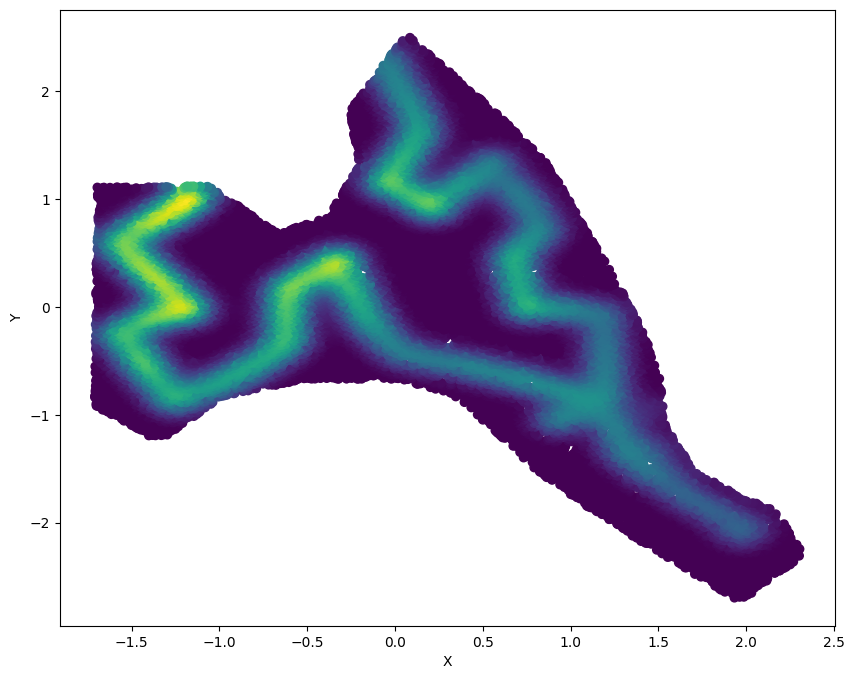

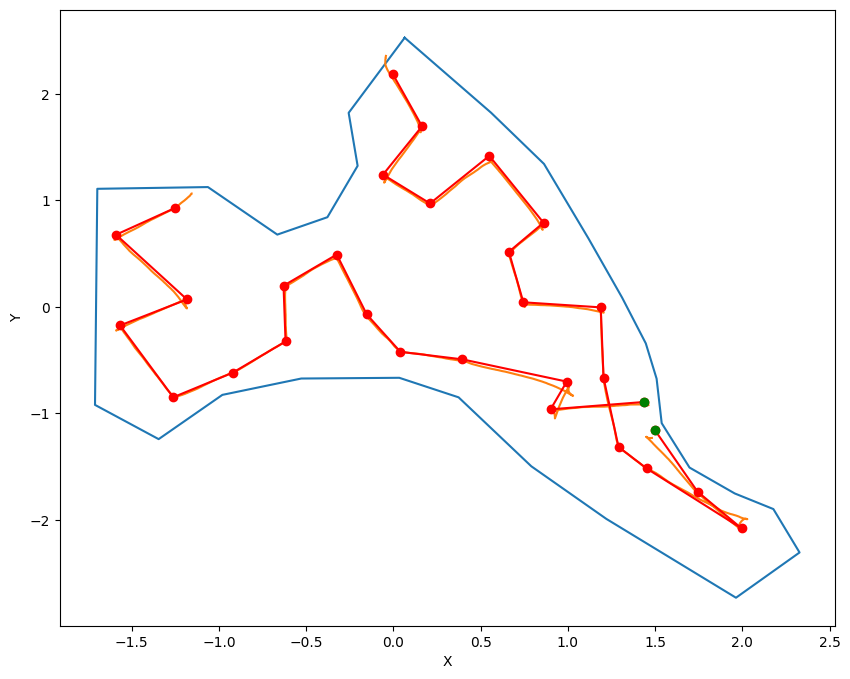

In [6]:
path = '../data/20240724/ASV1/mission6/'
X1, y1 = df2set(path)
df1 = pd.read_csv(path+'IPPMission-(-1).csv', 
                 header=None, delimiter=' ')
X_waypoints1 = np.vstack([df1[0].to_numpy(), df1[1].to_numpy()]).T

path = '../data/20240724/ASV2/mission6/'
X2, y2 = df2set(path)
df2 = pd.read_csv(path+'IPPMission-(-1).csv', 
                 header=None, delimiter=' ')
X_waypoints2 = np.vstack([df2[0].to_numpy(), df2[1].to_numpy()]).T

X_data = np.vstack([X1, X2])
y_data = np.vstack([y1, y2]).reshape(-1, 1)
gpr_pred = gpflow.models.GPR(data=(X_data, y_data), 
                             kernel=gpr_gt.kernel,
                             noise_variance=gpr_gt.likelihood.variance)
y_pred, _ = gpr_pred.predict_f(X_train)
y_pred = y_pred.numpy()
print(f'{get_rmse(y_pred, y_labels):.4f}')

plt.figure(figsize=(10, 8))
plt.scatter(X_train[:, 1], X_train[:, 0], c=y_pred)
plt.clim(y_labels.min(), y_labels.max())
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('2R-Discrete-15.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(boundary[:, 1], boundary[:, 0])
plt.plot(X1[:, 1], X1[:, 0], color='C1')
plt.plot(X2[:, 1], X2[:, 0], color='C1')
plt.plot(X_waypoints1[:, 1], X_waypoints1[:, 0], '-o', color='r')
plt.plot(X_waypoints2[:, 1], X_waypoints2[:, 0], '-o', color='r')
plt.plot(X_waypoints1[:1, 1], X_waypoints1[:1, 0], '-o', color='g')
plt.plot(X_waypoints2[:1, 1], X_waypoints2[:1, 0], '-o', color='g')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('2R-Discrete-15-paths.png', bbox_inches='tight')
plt.show()

# 2R-Continuous-15

1.7552


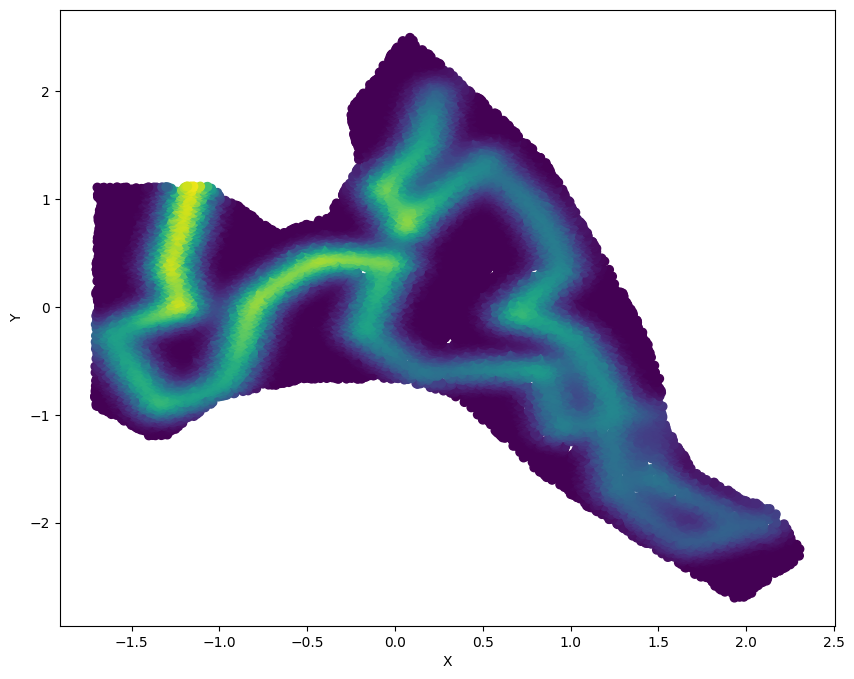

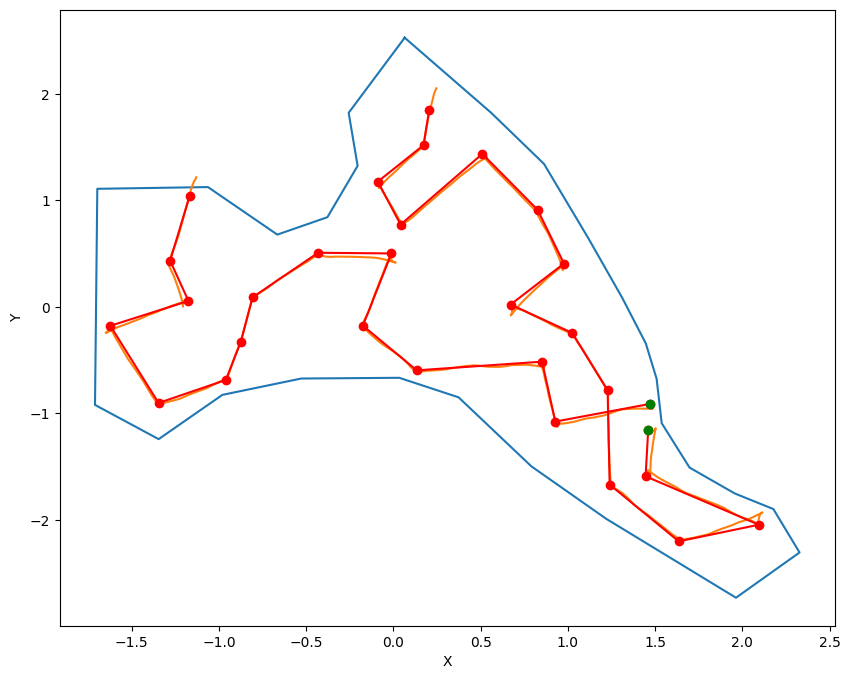

In [7]:
path = '../data/20240724/ASV1/mission11/'
X1, y1 = df2set(path)
df1 = pd.read_csv(path+'IPPMission-(-1).csv', 
                 header=None, delimiter=' ')
X_waypoints1 = np.vstack([df1[0].to_numpy(), df1[1].to_numpy()]).T

path = '../data/20240724/ASV2/mission11/'
X2, y2 = df2set(path)
df2 = pd.read_csv(path+'IPPMission-(-1).csv', 
                 header=None, delimiter=' ')
X_waypoints2 = np.vstack([df2[0].to_numpy(), df2[1].to_numpy()]).T

X_data = np.vstack([X1, X2])
y_data = np.vstack([y1, y2]).reshape(-1, 1)
gpr_pred = gpflow.models.GPR(data=(X_data, y_data), 
                             kernel=gpr_gt.kernel,
                             noise_variance=gpr_gt.likelihood.variance)
y_pred, _ = gpr_pred.predict_f(X_train)
y_pred = y_pred.numpy()
print(f'{get_rmse(y_pred, y_labels):.4f}')

plt.figure(figsize=(10, 8))
plt.scatter(X_train[:, 1], X_train[:, 0], c=y_pred)
plt.clim(y_labels.min(), y_labels.max())
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('2R-Continuous-15.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(boundary[:, 1], boundary[:, 0])
plt.plot(X1[:, 1], X1[:, 0], color='C1')
plt.plot(X2[:, 1], X2[:, 0], color='C1')
plt.plot(X_waypoints1[:, 1], X_waypoints1[:, 0], '-o', color='r')
plt.plot(X_waypoints2[:, 1], X_waypoints2[:, 0], '-o', color='r')
plt.plot(X_waypoints1[:1, 1], X_waypoints1[:1, 0], '-o', color='g')
plt.plot(X_waypoints2[:1, 1], X_waypoints2[:1, 0], '-o', color='g')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('2R-Continuous-15-paths.png', bbox_inches='tight')
plt.show()

# 1R-Discrete-30

1.7059


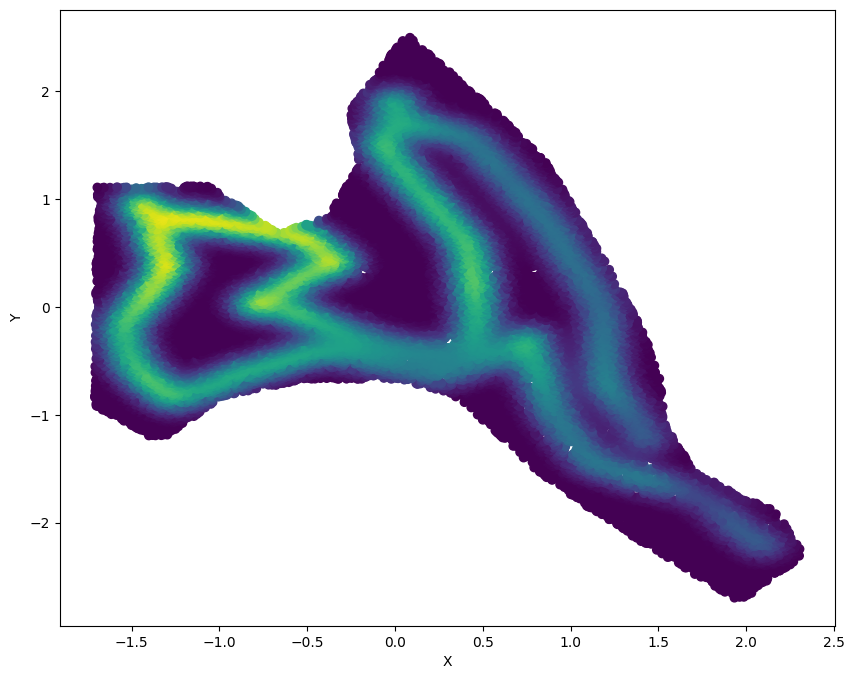

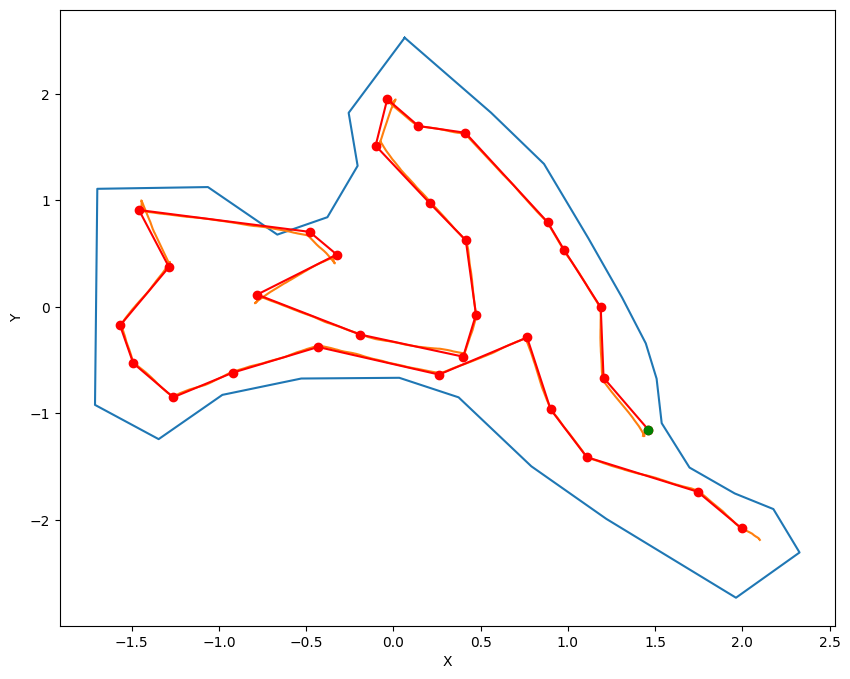

In [8]:
path = '../data/20240724/ASV1/mission7/'
X, y = df2set(path)
df = pd.read_csv(path+'IPPMission-(-1).csv', 
                 header=None, delimiter=' ')
X_waypoints = np.vstack([df[0].to_numpy(), df[1].to_numpy()]).T

X_data = X
y_data = y.reshape(-1, 1)
gpr_pred = gpflow.models.GPR(data=(X_data, y_data), 
                             kernel=gpr_gt.kernel,
                             noise_variance=gpr_gt.likelihood.variance)
y_pred, _ = gpr_pred.predict_f(X_train)
y_pred = y_pred.numpy()
print(f'{get_rmse(y_pred, y_labels):.4f}')

plt.figure(figsize=(10, 8))
plt.scatter(X_train[:, 1], X_train[:, 0], c=y_pred)
plt.clim(y_labels.min(), y_labels.max())
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('1R-Discrete-30.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(boundary[:, 1], boundary[:, 0])
plt.plot(X[:, 1], X[:, 0], color='C1')
plt.plot(X_waypoints[:, 1], X_waypoints[:, 0], '-o', color='r')
plt.plot(X_waypoints[:1, 1], X_waypoints[:1, 0], '-o', color='g')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('1R-Discrete-30-paths.png', bbox_inches='tight')
plt.show()

# 1R-Continuous-30

1.6103


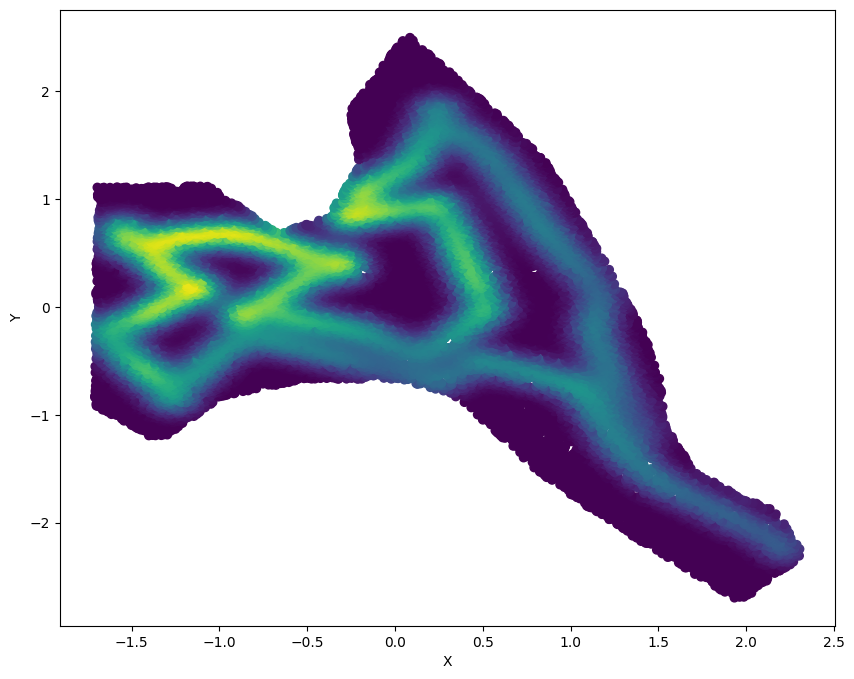

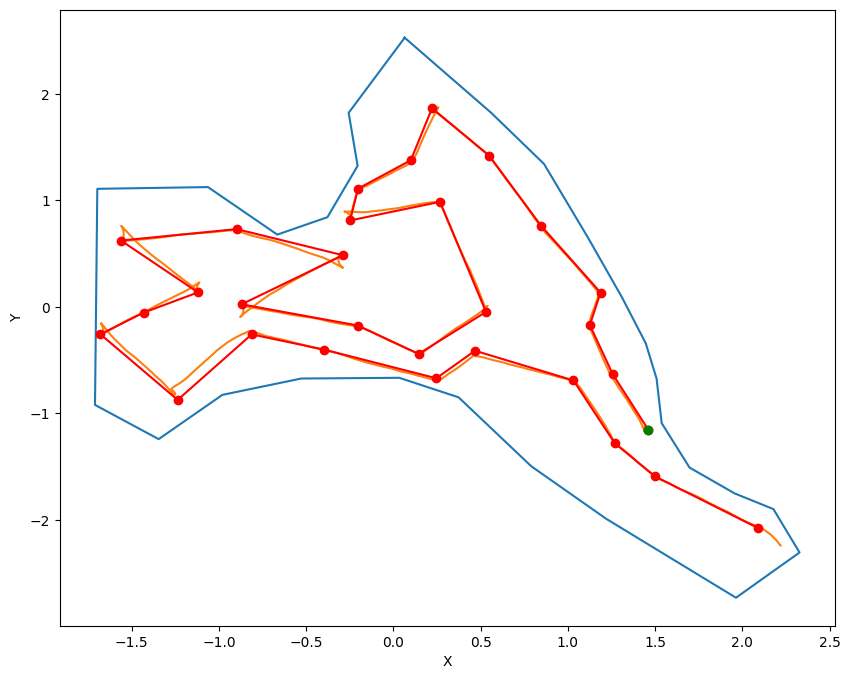

In [9]:
path = '../data/20240724/ASV1/mission10/'
X, y = df2set(path)
df = pd.read_csv(path+'IPPMission-(-1).csv', 
                 header=None, delimiter=' ')
X_waypoints = np.vstack([df[0].to_numpy(), df[1].to_numpy()]).T

X_data = X
y_data = y.reshape(-1, 1)
gpr_pred = gpflow.models.GPR(data=(X_data, y_data), 
                             kernel=gpr_gt.kernel,
                             noise_variance=gpr_gt.likelihood.variance)
y_pred, _ = gpr_pred.predict_f(X_train)
y_pred = y_pred.numpy()
print(f'{get_rmse(y_pred, y_labels):.4f}')

plt.figure(figsize=(10, 8))
plt.scatter(X_train[:, 1], X_train[:, 0], c=y_pred)
plt.clim(y_labels.min(), y_labels.max())
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('1R-Continuous-30.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(boundary[:, 1], boundary[:, 0])
plt.plot(X[:, 1], X[:, 0], color='C1')
plt.plot(X_waypoints[:, 1], X_waypoints[:, 0], '-o', color='r')
plt.plot(X_waypoints[:1, 1], X_waypoints[:1, 0], '-o', color='g')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('1R-Continuous-30-paths.png', bbox_inches='tight')
plt.show()